In [1]:
%matplotlib inline
import numpy as np
import pylab as pl
import sympy as sym
from sympy.functions import Abs
#from sympy import Abs, Symbol, S

## Goals of today:

- Check how good or bad are the estimates given in the theoretical lecture
- Compute errors, plot error tables
- Compare Equispaced with Chebyshev

## Lagrangian part

The estimate we want to check:

$$
|| f -p || \leq ||f^{n+1}||_\infty \frac{||w(x)||_\infty}{(n+1)!}
$$

in order to do so we need to define, simbolic and numerical functions. [`Sympy`]() is a very useful package to handle symbolic expressions and to export them to numerical functions. A the beginnnig of this notebook it is imported with the command: `import sympy as sym`. 

Let's start by defining a way to compute the $\|\cdot\|_\infty$ norm, in an approximate way, using numpy. 

We use an approximate way which is based on the computation of the $l^\infty$ norm on large n-dimensional vectors, that we use to evaluate and plot our functions.

Begin by defining a linear space, used to evaluate our functions.

In [2]:
# Using directly numpy broadcasting and max function
l_infty = lambda y: abs(y).max()

# Using full python lists and ranges
def l_infty_1(y):
    m = -1.0
    for i in range(len(y)):
        m = max(m, abs(y[i]))
    return m
    
# Iterating over numpy array entries
def l_infty_2(y):
    m = -1.0
    for i in y:
        m = max(m, abs(i))
    return m

# Using numpy norm function
l_infty_3 = lambda y: np.linalg.norm(y, ord=np.inf)

# Test it on a random vector of a million elements
yy = np.random.rand(int(1e6))

%timeit l_infty(yy)
%timeit l_infty_1(yy)
%timeit l_infty_2(yy)
%timeit l_infty_3(yy)

# The timings show that the manual numpy solution is the most efficient.
# The first version and the last do the exact same thing, 
# with the difference that the last has some overheads due to 
# parsing of the optional parameters, which is not there in the first version

4.37 ms ± 499 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
571 ms ± 51.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
493 ms ± 47.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.45 ms ± 491 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In order to compute derivatives and evaluate symbolic functions, we use sympy. Let's construct a symbolic variable, and define functions in terms of it:

In [3]:
# Now construct a symbolic function...
t = sym.var('t')
fs = 1.0/(1.0+t**2) # Runge function
print(fs)
fs.diff(t, 1)

1.0/(t**2 + 1.0)


-2.0*t/(t**2 + 1.0)**2

To make this function *digestible* by numpy we use the simple command `nf = sym.lambdify(t,f, 'numpy')`. This allows the function nf to be called with numpy arguments.

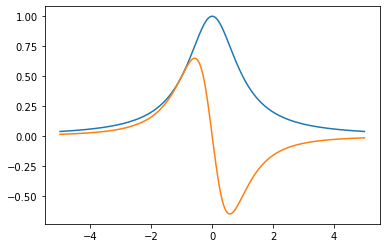

In [4]:
# Create a vector for the evaluation of functions, norms, etc.
x = np.linspace(-5,5, 2**10+1) 

# This won't work
# ns(x)

nf = sym.lambdify(t, fs, 'numpy')
nfprime = sym.lambdify(t, fs.diff(t,1), 'numpy')

# Now we can plot and evaluate the function on numpy arrays
_ = pl.plot(x,nf(x))
_ = pl.plot(x,nfprime(x))

Now we construct a small helper function that given a symbolic expression with one single free symbol, it returns a numpy aware lambda function of its n-th derivative, that can be used to evaluate numpy expressions.

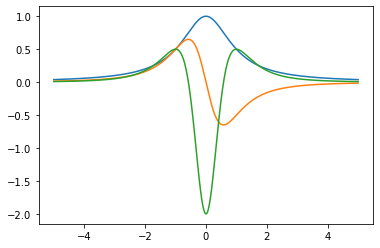

In [5]:
def der(f,n):
    assert len(f.free_symbols) == 1, "I can only do this for single variable functions..."
    t = f.free_symbols.pop()
    return sym.lambdify(t, f.diff(t, n), 'numpy')

f = der(fs, 0)
fp = der(fs, 1)
fpp = der(fs, 2)

# Stack columns and plot them all together
_ = pl.plot(x, np.c_[f(x), fp(x), fpp(x)])

In [6]:
# Check derivatives for two functions...
function_set = [fs, sym.sin(2*sym.pi*t)]

for my_f in function_set:
    print("****************")
    print(my_f)
    for i in range(5):
        print(l_infty(der(my_f,i)(x)))

****************
1.0/(t**2 + 1.0)
1.0
0.6495170207333653
2.0
4.668260905616381
24.0
****************
sin(2*pi*t)
1.0
6.283185307179586
39.47841760435743
248.05021344239853
1558.5454565440386


We aim at controlling all of the pieces of the inequality above, plot how terms behave with the degree, and see what happens `:)`

Good thing is to start from the beginning and control the term $||f-p||_\infty$. We recall that:
$$
p = \mathcal{L}^n f := \sum_{i=0}^n f(x_i) l^n_i(x),
$$

with

$$
l^n_i(x) := \prod_{j=0, j\neq i}^n \frac{(x-x_j)}{(x_i-x_j)}  \qquad
i = 0, \dots, n.
$$

Let's implment this guy. We want to fill the matrix `Ln` with $n+1$ rows and as many colums as the number of points where we evaluate the funtion. 

$$
\text{Ln}_{ij} := l_i(x_j)
$$

so that 

$$
\text{Ln}_{ij} f(q_i) = \sum_{i=0}^{n} l_i(x_j)f(q_i) = (\mathcal{L}^n f)(x_j)
$$

A good idea would be to collect the few operations in a function, like this one:
```python
def lagrangian_interpolation_matrix(x,q):
    ...
    return Ln
```
so that we can recall it whenever we need it.

**Hint:** I wouldn't call myself a good programmer, but I do my best to be like that. First construct the code in the main section of your program, run it, check that it works, then collect the precious commmands you wrote in an function.

### Step 0

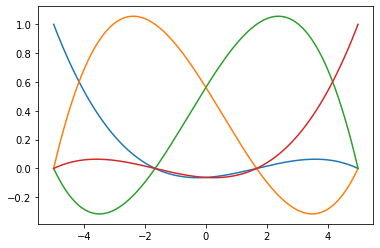

In [7]:
n = 3
q = np.linspace(-5,5,n+1)

Ln = np.zeros((n+1, len(x)))

for i in range(n+1):
    Ln[i] = np.ones_like(x)
    for j in range(n+1):
        if j != i:
            Ln[i] *= (x-q[j])/(q[i]-q[j])

    # Alternative one-liner...
    # Ln[i] = np.product([(x-q[j])/(q[i]-q[j]) for j in range(n+1) if j != i], axis=0)

_ = pl.plot(x, Ln.T)

## Step 1

Now we transform this into two function that takes the points where we want to compute the 
matrix, and the interpolation points we use to define the basis.

In [8]:
def lagrangian_interpolation_matrix(x,q):
    Ln = np.zeros((len(q), len(x)))

    for i in range(len(q)):
        Ln[i] = np.ones_like(x)
        for j in range(len(q)):
            if j != i:
                Ln[i] *= (x-q[j])/(q[i]-q[j])
    return Ln

def lagrangian_interpolation_matrix_one_liner(x,q):
    Ln = np.zeros((len(q), len(x)))
    for i in range(len(q)):
        Ln[i] = np.product([(x-q[j])/(q[i]-q[j]) for j in range(len(q)) if j != i], axis=0)
    return Ln


In [18]:
Error = lagrangian_interpolation_matrix(x,q) - lagrangian_interpolation_matrix_one_liner(x,q)

print("Error:", np.linalg.norm(Error))

Error: 0.0


From the previous lecture we know that the mathemathical expression:
$$
(\mathcal{L}^nf)(x_i) := \sum_{j=0}^n f(q_j) l^n_j(x_i) = (\text{Ln}^T f)_i
$$

Can be easyly translated into the `numpy` line:
```python
Ln.T.dot(f(x))
```
Let's give it a try:


sin(t)
Error: 1.308682565785193


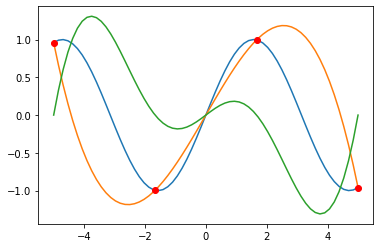

In [33]:
fs = sym.sin(t)
print(fs)
f = der(fs,0)

n = 3
q = np.linspace(-5,5,n+1)

Ln = lagrangian_interpolation_matrix(x,q)

_ = pl.plot(x, f(x)) #blue
_ = pl.plot(x, Ln.T.dot(f(q))) 
_ = pl.plot(q, f(q), 'or') #dots

e = f(x) - Ln.T.dot(f(q))
_ = pl.plot(x, e) #green

Error = l_infty(e)

print("Error:", Error)

Let's increase the number of points...

Error: 3.102363372775585e-05


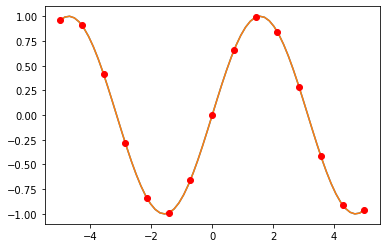

In [26]:
q = np.linspace(-5,5,15)
Ln = lagrangian_interpolation_matrix(x,q)

_ = pl.plot(x, f(x))
_ = pl.plot(x, Ln.T.dot(f(q)))
_ = pl.plot(q, f(q), 'ro')


e = f(x) - Ln.T.dot(f(q))

Error = l_infty(e)

print("Error:", Error)

Now compute the following

$||f-p||_\infty = $ `error`

$||f^{n+1}||_\infty = $ `nth_der`

$w(x) =\prod_{i=0}^n (x-q_i), \quad ||w(x)||_\infty = $ `w`

In [12]:
# define w
w = lambda x,q: np.product([x-q[i] for i in range(len(q))], axis=0)

q = np.linspace(-5,5,5)

Ln = lagrangian_interpolation_matrix(x,q)
error = l_infty(f(x) - Ln.T.dot(f(q)))

fs = sym.sin(2*sym.pi*t)
fp = der(fs, len(q))

nth_der = l_infty(fp(x))
w_infty = l_infty(w(x,q))

UpperEstimate = nth_der*w_infty/np.math.factorial(len(q))
print(UpperEstimate)

28939.83544506955


[12.499569820978111, 8.0108642578125, 5.142600069213905, 2.9493123292922974, 1.4969966196757913, 0.6718744848634512, 0.2750309743614048, 0.09926526267634017, 0.03387380988616557, 0.010382679231751846, 0.0028855720552535048, 0.000733005428107241, 0.00018625491033725313]


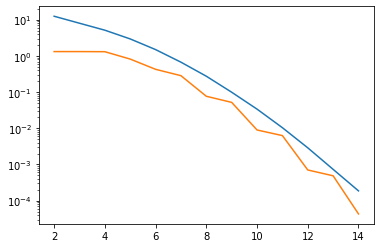

In [35]:
fs = sym.sin(t)

points = range(2,15)
UpperEstimate = []
ActualError = []

for n in points:
    q = np.linspace(-5,5,n)

    Ln = lagrangian_interpolation_matrix(x,q)
    ActualError.append(l_infty(f(x) - Ln.T.dot(f(q))))

    fp = der(fs, len(q))
    nth_der = l_infty(fp(x))
    
    w_infty = l_infty(w(x,q))

    UpperEstimate.append(nth_der*w_infty/np.math.factorial(len(q)))

print(UpperEstimate)

_ = pl.semilogy(points, UpperEstimate)
_ = pl.semilogy(points, ActualError) #segmented line

If I didn't mess the code this a good spot to play aroud with the function to be checked. Let's save everything into a single function. Let's also look forward. Instead of using by default equispaced points, lets' ask for a function that can generate the points for us, given x and q...

In [14]:
def check_errors(x, fs, n, generator=lambda x,n: np.linspace(x.min(),x.max(),n)):
    """
    Check the error for the interpolation obtained by calling 
    q = generator(x,i)
    for each i in the range(2,n).
    
    The default generator uses equispaced points.
    """
    points = range(2,n)
    UpperEstimate = []
    ActualError = []
    
    f = der(fs, 0)
    
    for n in points:
        q = generator(x,n)

        Ln = lagrangian_interpolation_matrix(x,q)
        ActualError.append(l_infty(f(x) - Ln.T.dot(f(q))))

        fp = der(fs, len(q))
        nth_der = l_infty(fp(x))

        w_infty = l_infty(w(x,q))

        UpperEstimate.append(nth_der*w_infty/np.math.factorial(len(q)))
    
    return (points, UpperEstimate, ActualError)

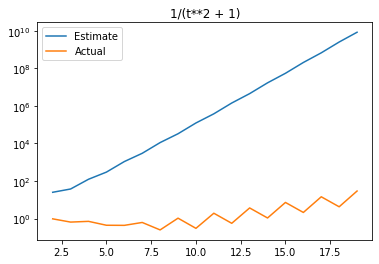

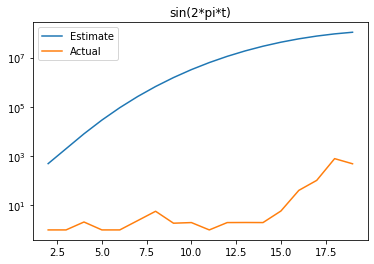

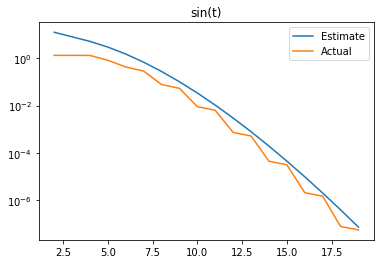

In [15]:
function_set = [1/(1+t**2), sym.sin(2*sym.pi*t), sym.sin(t)]

for fs in function_set:
    p, u, e = check_errors(x, fs, 20)
    
    _ = pl.semilogy(p, np.c_[u, e])
    pl.title(str(fs))
    pl.legend(['Estimate', 'Actual'])
    pl.show()

Now let's try to repeat the same thing with **Chebyshev** points...

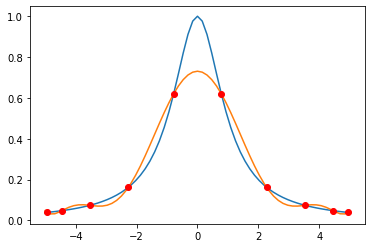

In [16]:
# We start by trying to interpolate the Runge function:

# Get a smaller sample of points...
x = np.linspace(-5,5,2**6+1)

# This is used to generate chebyshev points between xmin and xmax
generator = lambda x,n: x.min()+(x.max()-x.min())/2*(np.polynomial.chebyshev.chebgauss(n)[0]+1)

# 10 interpolation points
q = generator(x,10)

# The the Runge function
f = der(function_set[0], 0)

# The interpolation matrix
Ln = lagrangian_interpolation_matrix(x,q)

_ = pl.plot(x, np.c_[f(x), Ln.T.dot(f(q))])
_ = pl.plot(q, f(q), 'or')

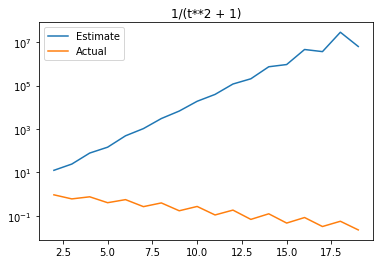

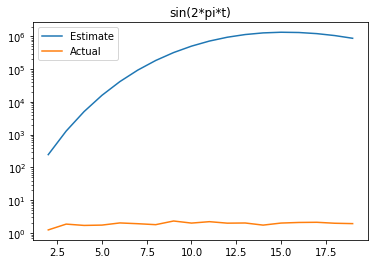

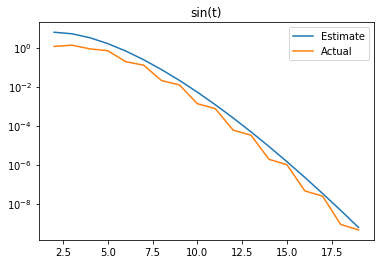

In [17]:
for fs in function_set:
    p, u, e = check_errors(x, fs, 20, generator)
    
    _ = pl.semilogy(p, np.c_[u, e])
    pl.title(str(fs))
    pl.legend(['Estimate', 'Actual'])
    pl.show()